In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
start = "2010-01-01"
end = "2019-12-31"

df = yf.download("AAPL", start, end)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,69.355133,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.421059,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.798416,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.771538,146266000
2019-12-30,72.364998,73.172501,71.305000,72.879997,71.191566,144114400


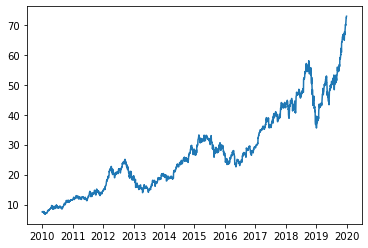

In [3]:
plt.plot(df.Close)

In [4]:
# ma - Moving Average, mean for a specified period of time, e.g 100 days, 200 days
ma100 = df.Close.rolling(100).mean()
ma100

Date
2009-12-31          NaN
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
                ...    
2019-12-23    59.201075
2019-12-24    59.401700
2019-12-26    59.643125
2019-12-27    59.875125
2019-12-30    60.106325
Name: Close, Length: 2516, dtype: float64

In [5]:
ma200 = df.Close.rolling(200).mean()
ma200

Date
2009-12-31          NaN
2010-01-04          NaN
2010-01-05          NaN
2010-01-06          NaN
2010-01-07          NaN
                ...    
2019-12-23    54.132313
2019-12-24    54.261513
2019-12-26    54.396763
2019-12-27    54.529350
2019-12-30    54.661100
Name: Close, Length: 2516, dtype: float64

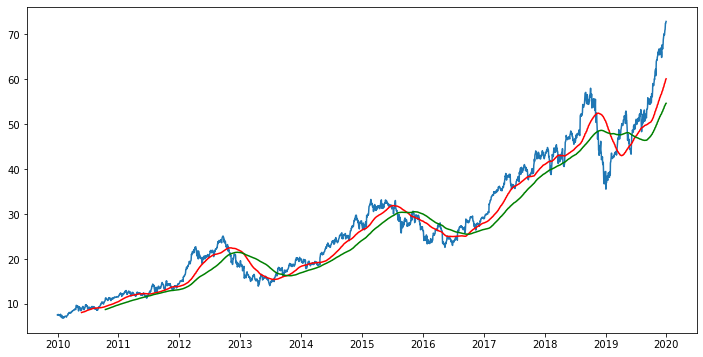

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, "r")
plt.plot(ma200, "g")

In [7]:
df.shape

(2516, 6)

In [8]:
# Split data into train and test
df = df.reset_index()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2511,2019-12-23,70.132500,71.062500,70.092499,71.000000,69.355133,98572000
2512,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.421059,48478800
2513,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.798416,93121200
2514,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.771538,146266000
2515,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.191566,144114400


In [9]:
# 70% training data and 30% testing data
data_train = pd.DataFrame(df["Close"][0 : int(len(df) * 0.70)])
data_test = pd.DataFrame(df["Close"][int(len(df) * 0.70) : int(len(df))])

print(data_train.shape)
print(data_test.shape)

(1761, 1)
(755, 1)


In [10]:
data_train.head()

,Close
0,7.526071
1,7.643214
2,7.656429
3,7.534643
4,7.520714


In [11]:
data_test.head()

,Close
1761,29.182501
1762,28.955000
1763,29.037500
1764,29.004999
1765,29.152500


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_array = scaler.fit_transform(data_train)
data_train_array

array([[0.02527908],
       [0.02971782],
       [0.03021854],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

In [16]:
data_train_array.shape

(1761, 1)

In [17]:
x_train = []
y_train = []

for i in range(100, data_train_array.shape[0]):
    x_train.append(data_train_array[i - 100: i])
    y_train.append(data_train_array[i, 0])
    
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# ML Model
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()

# First layer
model.add(LSTM(units=50, activation="relu", return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second layer
model.add(LSTM(units=60, activation="relu", return_sequences=True))
model.add(Dropout(0.3))

# Third layer
model.add(LSTM(units=80, activation="relu", return_sequences=True))
model.add(Dropout(0.4))

# Fourth layer
model.add(LSTM(units=120, activation="relu"))
model.add(Dropout(0.5))

# Connect all layers
model.add(Dense(units=1))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=50)

In [ ]:
model.save("s_trend_model")

In [ ]:
# Append the past 100 days to testing data
past_100_days = data_train.tail(100)
final_df = pd.concat([past_100_days, data_test], ignore_index=True)

In [ ]:
# Scale down testing data
input_data = scaler.fit_transform(final_df)
input_data
input_data.shape

In [ ]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i - 100: i])
    y_test.append(input_data[i, 0])
    
# Convert to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

In [ ]:
# Making Predictions
y_predicted = model.predict(x_test)
print(y_predicted.shape)
print(scaler.scale_)

# scale up
scale_factor = 1/0.02123255
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

plt.figure(figsize=(12,6))
plt.plot(y_test, "b", label="Original Price")
plt.plot(y_predicted, "r", label="Predicted Price")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()